# **B. Initial experiments on the MNIST case**
We will now move towards a multi-class setting, where we choose randomly from 5 different classes of objects. This multi-class setting aims to further complete the study by analyzing what happens to the network's performance when tested under a multi-class setting using a custom dataset on a custom 3D rendering engine such as Unity. By completing this part of the study, we seek to understand whether using a multi-class setting aliviates the problems encountered in the single-class setting, due to its simplicity and therefore tendency to overfit, or have vanishing gradients. The five different objects are as shown below. We will conduct this study as the previous one, but simplifying the hyperparameter search, since the previous case proved that only employing learning rate decay and changing the number of pretraining epochs are the two hyperparameter settings that most affect the performance of the network.

#### Library imports
Let us import all relevant libraries to analyse our results from each of the experiments.

In [1]:
import pandas as pd
import cv2
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook as tqdm

### **Helper functions**
Let us define all the functions that will help in this study.

#### General helper functions
Helper functions to read and write basic files.

In [2]:
PROG_PATH = 'progress'
GRAPH_PATH = 'graphs'
DIST_PATH = 'images'
FMAP_PATH = 'feature_maps'
TGT_PATH = 'images/target'
gen_PATH = '../data/datagen/scenes/unity/3d_scene_tgt/Builds/3dv1_Data/StreamingAssets/Snapshots'
GRAD_PATH = 'gradients'

# General helper functions
def import_npy(file_name):
    return np.load(file_name)

def import_json(file_name):
    with open(file_name, 'r') as f:
        config = json.load(f)
    
    return config

def import_csv(file_name):
    return pd.read_csv(file_name)

def import_png(file_name):
    img = cv2.imread(file_name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def walk_npy_folder(directory):
    npys = []
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.npy'):
                npy = import_npy(os.path.join(directory, filename))
                npys.append(npy)
        
        return np.array(npys)
    
    else:
        return np.empty((1,1))

def walk_json_folder(directory):
    jsons = []
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                json_ = import_json(os.path.join(directory, filename))
                jsons.append(json_)
        
        return jsons
    
    else:
        return []

def walk_jpg_folder(directory, n_samples):
    pngs = []
    random_sample = random.randint(0, n_samples)
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                file_n = int(filename.split('.')[0])
                if file_n == random_sample: 
                    png = import_png(os.path.join(directory, filename))
                    pngs.append(png)
        
        return pngs
    
    else:
        return []

def read_yaml(fname):
    with open(fname, 'r') as f:
        config = yaml.safe_load(f)

    return config

def read_hyperaparameters(experiment_n):
    hpams_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', 'hyperparameters', f'experiment{experiment_n}_hyperparameters.yaml')
    return read_yaml(hpams_path)

def pca_array(array, components=None):
    pca = PCA(n_components=components)
    return pca.fit_transform(array)

def jitter(values, std):
    return np.array(values) + np.random.normal(np.mean(values),std)

def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

#### GCN helper functions
Helper functions to plot data about the Graph Convolutional Network training progress.

In [18]:
# GCN helper functions
def get_GCN_progress(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    return import_csv(os.path.join(progress_path, 'gcn.csv'))

def plot_pretraining_progress(experiment_n, title, filename, size):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'gcn.csv'))
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=size)
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['class_loss'], label='classification loss', linewidth=3, alpha=0.8)
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['cont_loss'], label='content loss', linewidth=3, alpha=0.8)
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['loss'], label='total loss', linewidth=3, alpha=0.8)
    plt.legend(fontsize=15)
    plt.title(title, fontweight='bold', fontsize=15)
    plt.xlabel("epoch", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("loss", fontsize=15)
    sns.despine()
    fig.savefig(os.path.join(RESULTS_PATH, f'{filename}.pdf'), bbox_inches='tight')

def plot_pretraining_progress_grid(experiment_n, title, i):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'gcn.csv'))
    sns.set_style("white")
    plt.subplot(1, 3, i+1)
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['class_loss'], label='class loss')
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['cont_loss'], label='cont loss')
    plt.plot(gcn_progres['rec_epoch'], gcn_progres['loss'], label='(total) loss')
    plt.legend(fontsize=12)
    plt.title(title, fontsize=12)
    plt.xlabel("epoch", fontsize=12)
    plt.ylabel("loss", fontsize=12)
    plt.gcf().set_size_inches(18, 5)

def get_epoch_graphs(graph_path, epoch):
    graph_epoch_path = os.path.join(graph_path, f'epoch_{epoch}')
    return walk_npy_folder(graph_epoch_path)

def get_feature_graphs(experiment_n, dimension, interv):
    graph_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', GRAPH_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv

    feature_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        graph_features = get_epoch_graphs(graph_path, e)
        if len(graph_features) > 1:
            graph_features = np.reshape(graph_features, \
                (graph_features.shape[0]*graph_features.shape[1], graph_features.shape[2]))
            feature_dict[f'epoch_{e}'] =  pca_array(graph_features, \
                                                    components=dimension).T
            
        else:
            print("Full results not ready yet")
            break

    return feature_dict

def plot_gfeature_representation(experiment, components, interval):
    # Get all graph features in 3D representation
    graph_features = get_feature_graphs(experiment_n=experiment, dimension=components, interv=interval)

    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

    dim = len(graph_features)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Graph batch node feature representation", fontweight="bold", y=1.05)
    for i, epoch in enumerate(graph_features.keys()):
        # Get epoch's data
        node_features = graph_features[epoch]
        epoch = int(epoch.split('_')[-1])
        # Create figure
        # Creating plot
        if node_features.shape[0] == 3:
            ax = fig.add_subplot(1, dim, i+1, projection='3d')
            ax.scatter3D(node_features[0], node_features[1], node_features[2],\
                color = 'lightseagreen', s=40, edgecolors='white', linewidths=0.8, alpha=0.0025)
            plt.title(f"epoch {epoch}")

        else:
            ax = fig.add_subplot(1, dim, i+1)
            ax.scatter(node_features[0], node_features[1],\
                color = 'lightseagreen', s=40, edgecolors='white', linewidths=0.8, alpha=0.0025)
            plt.title(f"epoch {epoch}")
    plt.tight_layout()

#### Feature maps helper functions
Helper functions to plot data about the generated feature maps from the Meta-Sim network.

In [4]:
# Feature maps helper functions
def TSNE_fmaps(n_components, concat_array):
    components=n_components
    embedded = TSNE(n_components=components).fit_transform(concat_array).T

    return embedded

def get_e_fmaps_inception(fmap_folder, epoch_n, n_components):
    fmap_epoch_folder = os.path.join(fmap_folder, f'epoch_{epoch_n}', 'fmaps_2048')
    gen_tgt_dict = {'gen':[], 'tgt':[]}
    if os.path.isdir(fmap_epoch_folder):
        for filename in os.listdir(fmap_epoch_folder):
            if filename.endswith('.npy'):
                splitfname = filename.split('_')
                tgt_gen = splitfname[1]
                fmap_n = splitfname[0][-1]
                if tgt_gen == 'gen':
                    npy = import_npy(os.path.join(fmap_epoch_folder, filename))
                    gen_tgt_dict['gen'].append(npy)
                else:
                    npy = import_npy(os.path.join(fmap_epoch_folder, filename))
                    gen_tgt_dict['tgt'].append(npy)
        
        # Concatenate collected fmaps
        gen_tgt_dict['gen'] = TSNE_fmaps(n_components, np.concatenate(gen_tgt_dict['gen']))
        gen_tgt_dict['tgt'] = TSNE_fmaps(n_components, np.concatenate(gen_tgt_dict['tgt']))
    
    else:
        pass
    
    return gen_tgt_dict

def get_epoch_fmaps(experiment_n, interv, n_components):
    fmap_folder = os.path.join(ROOT_PATH, f'experiment{experiment_n}', FMAP_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv

    fmaps_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        fmaps = get_e_fmaps_inception(fmap_folder, e, n_components)
        if type(fmaps['gen']) != list:
            fmaps_dict[f'epoch_{e}'] = fmaps
            
        else:
            print("Full results not ready yet")
            break

    return fmaps_dict

def plot_feature_representation(experiment, components, interval):
    # Get all graph features in 3D representation
    fmap_features = get_epoch_fmaps(experiment, interval, components)
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})

    dim = len(fmap_features)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle("Inception feature maps", fontweight="bold", y=1.05)
    for i, epoch in enumerate(fmap_features.keys()):
        # Create figure
        if components == 3:
            ax = fig.add_subplot(1, dim, i+1, projection='3d')
            # Get components
            x_tgt, y_tgt, z_tgt = fmap_features[epoch]['tgt'][0],fmap_features[epoch]['tgt'][1],fmap_features[epoch]['tgt'][2]
            x_gen, y_gen, z_gen = fmap_features[epoch]['gen'][0],fmap_features[epoch]['gen'][1],fmap_features[epoch]['gen'][2]

            std_jitter = 0.001
            # Creating plot
            ax.scatter3D(jitter(x_tgt, std_jitter), jitter(y_tgt, std_jitter), jitter(z_tgt,std_jitter) , color = "green", label='Target', alpha=0.25)
            ax.scatter3D(jitter(x_gen,std_jitter), jitter(y_gen,std_jitter), jitter(z_gen,std_jitter) , color = "blue", label='Generated', alpha=0.25)
            plt.title(epoch)
            plt.legend()

        else:
            # Get components
            x_tgt, y_tgt= fmap_features[epoch]['tgt'][0],fmap_features[epoch]['tgt'][1]
            x_gen, y_gen= fmap_features[epoch]['gen'][0],fmap_features[epoch]['gen'][1]
            # Normalize components
            x_tgt, y_tgt = scale_to_01_range(x_tgt), scale_to_01_range(y_tgt)
            x_gen, y_gen = scale_to_01_range(x_gen), scale_to_01_range(y_gen)
            std_jitter = 0.0001
            # Creating plot
            ax = fig.add_subplot(1, dim, i+1)
            ax.scatter(jitter(x_tgt, std_jitter), jitter(y_tgt, std_jitter), color = "green", label='Target', alpha=0.25)
            ax.scatter(jitter(x_gen,std_jitter), jitter(y_gen,std_jitter), color = "blue", label='Generated', alpha=0.25)
            plt.title(epoch)
            plt.legend()

    plt.tight_layout()                                             

#### Distribution helper functions
Helper functions to plot data about the generated distributions.

##### Distribution helper helper functions

In [5]:
# Distribution helper functions
def get_epoch_dist(dist_path, epoch):
    dist_epoch_path = os.path.join(dist_path, f'epoch_{epoch}')
    return walk_json_folder(dist_epoch_path)

def get_epoch_imgs(imgs_path, epoch, max_samples):
    imgs_epoch_path = os.path.join(imgs_path, f'epoch_{epoch}')
    return walk_jpg_folder(imgs_epoch_path, max_samples)

def get_distributions(experiment_n, interv, parameter):
    graph_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', DIST_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv
    dist_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        dist_samples = get_epoch_dist(graph_path, e)
        if len(dist_samples) > 1:
            dist_dict[f'epoch_{e}'] = []
            for dist_sample in dist_samples:
                if type(dist_sample) != list:
                    continue
                else:
                    dist_dict[f'epoch_{e}'].append(dist_sample[0][parameter])
            
        else:
            print("Full results not ready yet")
            break
    
    return dist_dict

def get_tgt_distribution(experiment_n, parameter):
    tgt_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', TGT_PATH)
    tgt_dist_dict = walk_json_folder(tgt_path)
    final_dict= {'tgt_dist':[]}
    for tgt in tgt_dist_dict:
        if type(tgt) != list:
            continue
        else:
            final_dict['tgt_dist'].append(tgt[0][parameter])
    
    return final_dict

def get_distributions_bbox(experiment_n, interv, parameter):
    graph_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', DIST_PATH)
    hpams = read_hyperaparameters(experiment_n)
    total_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    interval = interv
    dist_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        dist_samples = get_epoch_dist(graph_path, e)
        if len(dist_samples) > 1:
            dist_dict[f'epoch_{e}'] = []
            for dist_sample in dist_samples:
                if type(dist_sample) != list:
                    continue
                else:
                    if parameter == 'loc_x':
                        dist_dict[f'epoch_{e}'].append(dist_sample[0]['bbox'][0])
                    else:
                        dist_dict[f'epoch_{e}'].append(dist_sample[0]['bbox'][1])

            
        else:
            print("Full results not ready yet")
            break
    
    return dist_dict

def get_tgt_distribution_bbox(experiment_n, parameter):
    tgt_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', TGT_PATH)
    tgt_dist_dict = walk_json_folder(tgt_path)
    final_dict= {'tgt_dist':[]}
    for tgt in tgt_dist_dict:
        if type(tgt) != list:
            continue
        else:
            if parameter == 'loc_x':
                final_dict['tgt_dist'].append(tgt[0]['bbox'][0])
            else:
                final_dict['tgt_dist'].append(tgt[0]['bbox'][1])
    
    return final_dict

def get_distdf(experiment_n, interval, parameter='yaw'):
    # Get target distributions
    dist_dict = get_distributions(experiment_n=experiment_n, interv=interval, parameter=parameter)
    tgt_dict = get_tgt_distribution(experiment_n=4, parameter=parameter)
    # Get dataframe
    dist_dict['tgt_dist'] = tgt_dict['tgt_dist']

    return pd.DataFrame.from_dict(dist_dict)

def get_tgt_image(max_tgt_samples, experiment_n):
    tgt_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', TGT_PATH)
    tgt_image = walk_jpg_folder(tgt_path, max_tgt_samples)
    return tgt_image[0]

def get_gen_images(experiment_n, interv, total_epochs):
    imgs_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', DIST_PATH)
    hpams = read_hyperaparameters(experiment_n)
    #stotal_epochs = hpams['max_epochs']
    freq = hpams['distprint_freq']
    max_samples = hpams['epoch_length']
    max_tgt_samples = hpams['num_real_images']
    interval = interv

    imgs_dict = {}
    for e in range(0, total_epochs+1, freq*interval):
        dist_samples = get_epoch_imgs(imgs_path, e, max_samples)
        if len(dist_samples) == 1:
            imgs_dict[f'epoch_{e}'] = dist_samples[0]
            
        else:
            print("Full results not ready yet")
            break
    
    # Add target image
    imgs_dict['Target image'] = get_tgt_image(max_tgt_samples, experiment_n)
    return imgs_dict

##### Full distribution helpers 

In [179]:
def plot_distributions(experiment, interval, parameter='yaw', title="No title"):
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment, parameter)
    # Get target distributions
    dist_dict = get_distributions(experiment, interval, parameter)
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    fig = plt.figure(figsize = (10, 3))
    colors = []
    # Plot generated distributions
    for epoch_n in dist_dict.keys():
        e = int(epoch_n.split('_')[-1]) 
        angles = dist_dict[epoch_n]
        if np.mean(angles) < 0.1:
            angles = list(np.array(angles))

        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])
        plt.bar(bin_centers,hist,width=bin_widths, label=epoch_n, joinstyle='bevel')
        plot = plt.plot(bin_centers, hist, linewidth=3)
        colors.append(plot[0].get_color())

    # Plot target distribution
    tgt_angles = tgt_dist_dict['tgt_dist']    
    #tgt_angles = list(np.array(tgt_angles)+ np.random.normal(0,0.1,np.array(tgt_angles).shape))

    hist,edges = np.histogram(tgt_angles, bins=20)
    bin_centers = 0.5*(edges[:-1] + edges[1:])
    bin_widths = (edges[1:]-edges[:-1])

    plt.bar(bin_centers,hist,width=bin_widths, alpha=0.7, label='Target dist.', joinstyle='bevel')
    plot = plt.plot(bin_centers, hist, linewidth=3, color='salmon', alpha=0.7)
    colors.append(plot[0].get_color())
    # Finalize plot
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xlabel(f'{parameter}')
    plt.ylabel('frequency')
    plt.show()

def plot_distribution_grid(experiment, rows=2, columns=2, size=(15,8), interval=2, parameter='yaw', title="No title", i=1):
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment, parameter)
    # Get target distributions
    dist_dict = get_distributions(experiment, interval, parameter)
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    fig = plt.subplot(rows, columns, i+1)
    colors = []
    # Plot generated distributions
    for epoch_n in dist_dict.keys():
        angles = dist_dict[epoch_n]
        label = ' '.join(epoch_n.split('_'))
        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])
        plt.bar(bin_centers,hist,width=bin_widths, linewidth=0.01, label=label, joinstyle='bevel', alpha=0.6)
        plot = plt.plot(bin_centers, hist, linewidth=3, alpha=0.6)
        colors.append(plot[0].get_color())

    # Plot target distribution
    tgt_angles = tgt_dist_dict['tgt_dist']    
    hist,edges = np.histogram(tgt_angles, bins=20)
    bin_centers = 0.5*(edges[:-1] + edges[1:])
    bin_widths = (edges[1:]-edges[:-1])

    plt.bar(bin_centers,hist,width=bin_widths, linewidth=0.01,alpha=0.6, label='Target dist.', joinstyle='bevel')
    plot = plt.plot(bin_centers, hist, linewidth=3, alpha=0.6)
    colors.append(plot[0].get_color())
    # Finalize plot
    plt.title(title, fontsize=16)
    plt.gcf().set_size_inches(size[0], size[1])
    plt.legend(loc='upper left', prop={'size': 13}, ncol=1, bbox_to_anchor=(0.98, 1.05))
    plt.xlabel(f'{parameter}', fontsize=15)
    plt.xticks(fontsize=14)
    if i == 0:
        plt.ylabel('frequency', fontsize=15)
    plt.yticks(fontsize=14)

    return fig

def plot_each_distribution(experiment, interval, parameter='yaw'):
    # Plot joint plot and get colors
    colors = plot_distributions(experiment, interval, parameter)
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment, parameter)
    # Get target distributions
    dist_dict = get_distributions(experiment, interval, parameter)
    dist_dict['Target dist'] = tgt_dist_dict['tgt_dist']
    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    dim = len(dist_dict)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle(f"Generated distributions for {parameter} parameter at each key epoch", fontweight="bold", y=1.05)
    # Plot generated distributions
    for i, epoch_n in enumerate(dist_dict.keys()):
        ax = fig.add_subplot(1, dim, i+1)
        angles = dist_dict[epoch_n]
        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])
        label = ' '.join(epoch_n.split('_'))

        ax.bar(bin_centers,hist,width=bin_widths, alpha=0.7, label=label, color=colors[i], joinstyle='bevel', linewidth=0.01)
        ax.plot(bin_centers, hist, linewidth=1, color= colors[i], alpha=0.7)

        # Finalize plot
        plt.title(f"{epoch_n}")
        plt.xlabel(f'{parameter}')
    
    plt.ylabel('frequency')
    plt.show()

def plot_each_image(experiment_n, interval, filename, total_epochs, title):
    # Get target distribution
    epoch_images = get_gen_images(experiment_n, interval, total_epochs)

    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

    dim = len(epoch_images)
    fig = plt.figure(figsize = (dim*5, (dim*5)/dim))
    plt.suptitle(title, fontweight="bold", fontsize=32, y=1.09)
    # Plot generated distributions
    for i, epoch_n in enumerate(epoch_images.keys()):
        ax = fig.add_subplot(1, dim, i+1)
        plt.imshow(epoch_images[epoch_n], label=' '.join(epoch_n.split('_')))
        # Finalize plot
        #plt.title(' '.join(epoch_n.split('_')), fontsize=18)
        plt.text(0.01,.93,' '.join(epoch_n.split('_')), fontsize=32, transform=ax.transAxes, backgroundcolor='1',alpha=1)
        plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    
    plt.tight_layout()
    fig.savefig(os.path.join(RESULTS_PATH, f'{filename}.pdf'), bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_initial_distributions(experiment_n=1, interval=4, rows=1, columns=3, parameter="yaw", title="No title"):
    # Get target distribution
    tgt_dist_dict = get_tgt_distribution(experiment_n, parameter)
    # Get target distributions
    dist_dict = get_distributions(experiment_n, interval, parameter)
    dist_dict['Target dist.'] = tgt_dist_dict['tgt_dist']

    # Creating figure
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
    # generate some data
    x = np.arange(0, 10, 0.2)
    y = np.sin(x)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 3), gridspec_kw={'width_ratios': [6, 2, 2]})
    axes = [ax1,ax2,ax3]
    plt.suptitle(title, fontweight="bold", fontsize=12, y=1.05)

    # ax1
    # Plot generated distributions
    for epoch_n in dist_dict.keys():
        angles = dist_dict[epoch_n]
        hist,edges = np.histogram(angles, bins=20)
        bin_centers = 0.5*(edges[:-1] + edges[1:])
        bin_widths = (edges[1:]-edges[:-1])
        if epoch_n == 'Target dist.':
            ax1.bar(bin_centers,hist,width=bin_widths, label=epoch_n, color="tab:pink",joinstyle='bevel',alpha=0.7, linewidth=0.01)
            ax1.plot(bin_centers, hist, color="tab:pink", linewidth=3, alpha=0.7)
        else:
            ax1.bar(bin_centers,hist,width=bin_widths, label=epoch_n, joinstyle='bevel',alpha=0.7, linewidth=0.01)
            ax1.plot(bin_centers, hist, linewidth=3, alpha=0.7)

    # Finalize plot
    ax1.set_title("Genenerated distributions at each key epoch")
    ax1.legend(loc='upper right')
    ax1.set_xlabel(f'{parameter}')
    ax1.set_ylabel('frequency')

    # ax1
    angles = dist_dict['epoch_0']
    hist,edges = np.histogram(angles, bins=20)
    bin_centers = 0.5*(edges[:-1] + edges[1:])
    bin_widths = (edges[1:]-edges[:-1])
    label = ' '.join(epoch_n.split('_'))

    ax2.bar(bin_centers,hist,width=bin_widths, alpha=0.7, color='tab:blue', joinstyle='bevel', linewidth=0.01)
    ax2.plot(bin_centers, hist, linewidth=1, color= 'tab:blue', alpha=0.7)

    # Finalize plot
    ax2.set_title("Distribution at epoch 0")
    ax2.set_xlabel("yaw")

    # ax3
    angles = dist_dict['Target dist.']
    hist,edges = np.histogram(angles, bins=20)
    bin_centers = 0.5*(edges[:-1] + edges[1:])
    bin_widths = (edges[1:]-edges[:-1])

    ax3.bar(bin_centers,hist,width=bin_widths, alpha=0.7, color='tab:pink', joinstyle='bevel', linewidth=0.01)
    ax3.plot(bin_centers, hist, linewidth=1, color= 'tab:pink', alpha=0.7)

    # Finalize plot
    ax3.set_title("Target distribution")
    ax3.set_xlabel("yaw")
    fig.tight_layout()

def plot_translation_distribution(experiment_n, interval):
        epochx_dictionnary = get_distributions(experiment_n=experiment_n, interv=interval, parameter='loc_x')
        epochz_dictionnary = get_distributions(experiment_n=experiment_n, interv=interval, parameter='loc_z')
        tgtx_dictionnary = get_tgt_distribution(experiment_n=experiment_n, parameter='loc_x')
        tgtz_dictionnary = get_tgt_distribution(experiment_n=experiment_n, parameter='loc_z')

        x_tgt = tgtx_dictionnary['tgt_dist']
        z_tgt = tgtz_dictionnary['tgt_dist']

        fig,ax=plt.subplots(figsize=(7,7))
        fig.subplots_adjust(left=0.1, right=0.875, top=0.9,bottom=0.125)

        for epoch in epochx_dictionnary.keys():
            x_gen = epochx_dictionnary[epoch]
            z_gen = epochz_dictionnary[epoch]
            ax.scatter(x_gen, z_gen, label=f'{epoch}', alpha=0.25)

        ax.scatter(x_tgt, z_tgt, alpha=0.5, label='Target')

        ax.set_xlabel("loc_x", rotation=0, fontsize=12)
        ax.invert_xaxis()
        #ax.xaxis.tick_top()
        ax.xaxis.set_label_position('bottom') 
        ax.set_ylabel("loc_z", rotation=0, fontsize=12)
        ax.invert_yaxis()
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        plt.setp(ax.get_xticklabels(), rotation=0, va="top", ha="center")
        plt.setp(ax.get_yticklabels(), rotation=0, va="center", ha="left")

        ax.text(0.5,1.06,"Translation distribution", ha="center", va="center",
                transform=ax.transAxes, rotation=0, fontweight='bold', fontsize=14)

        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
def create_locations_df(experiment_n, interval):
    epochx_dictionnary = get_distributions_bbox(experiment_n=experiment_n, interv=interval, parameter='loc_x')
    epochy_dictionnary = get_distributions_bbox(experiment_n=experiment_n, interv=interval, parameter='loc_y')
    tgtx_dictionnary =get_tgt_distribution_bbox(experiment_n=experiment_n, parameter='loc_x')
    tgty_dictionnary =get_tgt_distribution_bbox(experiment_n=experiment_n, parameter='loc_y')
    epochx_dictionnary['Target dist.'] = tgtx_dictionnary['tgt_dist']
    epochy_dictionnary['Target dist.'] = tgty_dictionnary['tgt_dist']

    dict_df = {"loc x":[], "loc y":[], "Epoch":[]}

    for epoch in epochx_dictionnary.keys():
        dict_df['loc x'] = dict_df['loc x'] + epochx_dictionnary[epoch] 
        dict_df['loc y'] = dict_df['loc y'] + epochy_dictionnary[epoch] 
        dict_df['Epoch'] = dict_df['Epoch'] + [" ".join(epoch.split("_"))]*len(epochx_dictionnary[epoch])

    return pd.DataFrame.from_dict(dict_df)

def create_camrotations_df(experiment_n, interval):
    epochx_dictionnary = get_distributions(experiment_n=experiment_n, interv=interval, parameter='camera_pitch')
    epochz_dictionnary = get_distributions(experiment_n=experiment_n, interv=interval, parameter='camera_roll')
    tgtx_dictionnary =get_tgt_distribution(experiment_n=experiment_n, parameter='camera_pitch')
    tgtz_dictionnary =get_tgt_distribution(experiment_n=experiment_n, parameter='camera_roll')
    epochx_dictionnary['Target dist.'] = tgtx_dictionnary['tgt_dist']
    epochz_dictionnary['Target dist.'] = tgtz_dictionnary['tgt_dist']

    dict_df = {"camera pitch":[], "camera roll":[], "Epoch":[]}

    for epoch in epochx_dictionnary.keys():
        dict_df['camera pitch'] = dict_df['camera pitch'] + epochx_dictionnary[epoch] 
        dict_df['camera roll'] = dict_df['camera roll'] + epochz_dictionnary[epoch] 
        dict_df['Epoch'] = dict_df['Epoch'] + [" ".join(epoch.split("_"))]*len(epochx_dictionnary[epoch])

    return pd.DataFrame.from_dict(dict_df)

def plot_loc_dist_grid(experiment_n, height, title, filename, legend, xlabel, ylabel):
    loc_df = create_locations_df(experiment_n=experiment_n, interval=2)
    jointgrid = sns.jointplot(data=loc_df, 
                              x="loc x", 
                              y="loc y", 
                              hue="Epoch", 
                              height=height, xlim=(-5, 45), ylim=(-5, 45),
                              alpha=0.05, legend=legend)
    #jointgrid.fig.axes[0].invert_xaxis()
    jointgrid.fig.axes[0].invert_yaxis()
    jointgrid.set_axis_labels(xlabel, ylabel, fontsize=13)
    jointgrid.fig.suptitle(title, fontsize=12)
    jointgrid.fig.tight_layout()
    jointgrid.fig.subplots_adjust(top=0.95)
    jointgrid.savefig(os.path.join(RESULTS_PATH, f'{filename}.pdf'))

def plot_camera_dist_grid(experiment_n, interval, columns, size, title):
    loc_df = create_camrotations_df(experiment_n=experiment_n, interval=interval)
    jointgrid = sns.jointplot(data=loc_df, x="camera pitch", y="camera roll", hue="Epoch", alpha=0.25)
    jointgrid.fig.axes[0].invert_xaxis()
    jointgrid.fig.axes[0].invert_yaxis()
    jointgrid.fig.suptitle(title, fontsize=12)
    jointgrid.fig.tight_layout()
    jointgrid.fig.subplots_adjust(top=0.95)

def create_3D_rotation(exp_list, interval, title, sub_titles):
    # Define basic information
    dim = len(exp_list)
    sns.set_style('whitegrid')
    sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})
    fig = plt.figure(figsize = (dim*5, dim*5/dim))
    plt.suptitle(title, fontweight="bold", fontsize=18, y=1.03)
    
    for i,experiment_n in enumerate(exp_list):
        ax = fig.add_subplot(1, 4, i+1, projection='3d')
        # Get distributions
        dist_dict_yaw = get_distributions(experiment_n=experiment_n, interv=interval, parameter='yaw')
        dist_dict_pitch = get_distributions(experiment_n=experiment_n, interv=interval, parameter='pitch')
        dist_dict_roll = get_distributions(experiment_n=experiment_n, interv=interval, parameter='roll')
        tgt_dict_yaw = get_tgt_distribution(experiment_n=experiment_n, parameter='yaw')
        tgt_dict_pitch = get_tgt_distribution(experiment_n=experiment_n, parameter='pitch')
        tgt_dict_roll = get_tgt_distribution(experiment_n=experiment_n, parameter='roll')
        # Get dataframe
        dist_dict_yaw['Target_dist.'] = tgt_dict_yaw['tgt_dist']
        dist_dict_pitch['Target_dist.'] = tgt_dict_pitch['tgt_dist']
        dist_dict_roll['Target_dist.'] = tgt_dict_roll['tgt_dist']

        for e, epoch in enumerate(dist_dict_yaw.keys()):
            # Get components
            pitch, yaw, roll = dist_dict_pitch[epoch], dist_dict_yaw[epoch], dist_dict_roll[epoch]
            # Creating plot
            ax.scatter(pitch, yaw, roll, label=' '.join(epoch.split('_')), alpha=0.85)
        
        plt.title(sub_titles[i], fontsize=14)
        ax.set_xlabel('pitch (x)')
        ax.set_ylabel('yaw (y)')
        ax.set_zlabel('roll (z)')

        if i == 2:
            plt.legend(loc='lower center', prop={'size': 10})
    
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.1)

#### Gradients and MMD helper functions
Helper functions to plot data about the training progress.

In [139]:
# Gradients and MMD helper functions
def plot_MMD_loss(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'mmd.csv'))
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(gcn_progres['epoch'], gcn_progres['mmd_loss'], color='teal',label='MMD loss')
    plt.legend(fontsize=12)
    plt.title(f"MMD loss after training", fontweight='bold', fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.show()

def plot_accuracy(experiment_n):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'mmd.csv'))
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(gcn_progres['epoch'], gcn_progres['task_acc'], color='teal',label='MMD loss')
    plt.legend(fontsize=12)
    plt.title(f"MMD loss after training", fontweight='bold', fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.show()

def plot_MMD_loss_joint(experiment_n, label, limit=None):
    progress_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', PROG_PATH)
    gcn_progres = import_csv(os.path.join(progress_path, 'mmd_mnist.csv'))
    plt.plot(gcn_progres['epoch'][:limit], gcn_progres['mmd_loss'][:limit], label=label, alpha=0.8, linewidth=3)
    plt.legend(fontsize=15, loc='lower center')

def plot_gradients(experiment_n, interval):
    gradient_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', GRAD_PATH)
    sns.set_style("white")
    sns.despine(left=True, bottom=True)
    fig, ax = plt.subplots(figsize=(10,5))
    for epoch in range(0, 11, interval):
        epoch_grad_path = os.path.join(gradient_path, f'grads_e_{epoch}.csv') 
        epoch_grad_df = pd.read_csv(epoch_grad_path)
        #layer_names = ['_'.join(layer_name.split('.')[:]) for layer_name in epoch_grad_df['layer']]
        layer_names = ['_'.join(layer_name.split('.')[3:])+f"_{i}" for i,layer_name in enumerate(epoch_grad_df['layer'])]
        batches = list(epoch_grad_df.columns[1:])
        # change slice to 23 when not wanting to print encoder gradients
        slice_ = 23
        plt.plot(layer_names[slice_:], epoch_grad_df[slice_:].sum(axis=1), \
            color='teal', alpha=(1-(0.1*epoch)), label=f'Epoch {epoch}')
        plt.xticks(rotation=45, fontsize=8)
    sns.despine(left=True, bottom=True)
    plt.title("GCN decoder gradient flow", fontweight='bold', fotnsize=15)
    plt.legend()
    plt.show()

def plot_gradients_grid(experiment_n, rows, columns, size, interval,limit, title, alpha_mult, i):
    gradient_path = os.path.join(ROOT_PATH, f'experiment{experiment_n}', GRAD_PATH)
    sns.set_style("white")
    fig = plt.subplot(rows, columns, i+1)
    for epoch in range(0, limit, interval):
        epoch_grad_path = os.path.join(gradient_path, f'grads_e_{epoch}.csv') 
        epoch_grad_df = pd.read_csv(epoch_grad_path)
        #layer_names = ['_'.join(layer_name.split('.')[:]) for layer_name in epoch_grad_df['layer']]
        layer_names = ['_'.join(layer_name.split('.')[4:])+f"_{i}" for i,layer_name in enumerate(epoch_grad_df['layer'])]
        batches = list(epoch_grad_df.columns[1:])
        # change slice to 23 when not wanting to print encoder gradients
        slice_ = 23
        plt.plot(layer_names[slice_:], epoch_grad_df[slice_:].sum(axis=1), \
            color='teal', alpha=(1-(alpha_mult)*epoch), label=f'epoch {epoch}', linewidth=2.5)
        plt.xticks(rotation=90, fontsize=15)
        plt.yticks(fontsize=15)
    sns.despine(left=True, bottom=True)
    plt.gcf().set_size_inches(size[0], size[1])
    plt.title(title, fontsize=17)
    return fig

## **B.1. Learning to rotate 9 digits 90 degrees**
As per the previous section, we will define a target distribution centered around 90 degrees of standard deviation X, and we will initialize our distribution around 180 degrees with a standard deviation Y. As per the previous experiments, we wish our model to converge towards the target mean while keeping the standard deviation Y. This was not achievable under the explored settings in the previous sections. We hope that, by having more classes, this will help as a regularizer to the vanishing gradient problem observed before when increasing the number of pretraining epochs. Let us start by analyzing the pretraining performance of the GCN autoencoder.

In [165]:
ROOT_PATH = '../results/mnist/1_attr'
RESULTS_PATH = 'figures/mnist/1_attr/B_1'

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


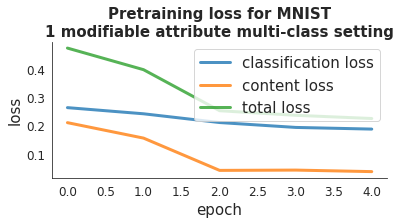

In [164]:
plot_pretraining_progress(experiment_n=1, 
                          title="Pretraining loss for MNIST\n1 modifiable attribute multi-class setting",
                          filename='mnist_1attr_GCN_progress',
                          size=(6,2.5))

We can clearly see that, in contrast to the previous experiments where it was a single class setting, in this case the classification loss (class loss depicted in blue in the figure) is strictly higher than the content loss. This is clearly due to the fact that in this case we have a random sampler that assigns different random classes to the object node in the graph. The GCN here needs to learn how to sample according to the randomness initiated by the probablistic grammar sampling.

According to this, we decide to train our model for 10 MMD epochs after 1, 5, and 10 pretraining epochs, and similarly with learning rate decay every 2 epochs. In the following distribution plot we only plot results for 1 and 10 pretraining epochs, since these expressed more information about the impact of pretraining and learning rate decay in a Meta-Sim multi-class setting. The figure can be seen below.

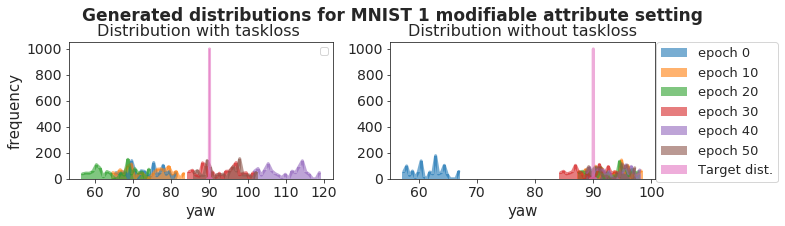

In [182]:
# Plot grid of distributions
titles = ['Distribution with taskloss ',
          'Distribution without taskloss']
# Experiment list
exp_list = [1,2]
# Plot distribution grid
plt.suptitle("Generated distributions for MNIST 1 modifiable attribute setting", fontsize=17,fontweight='bold', y=1.03)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(experiment=exp, 
                    interval=2,
                    size=(11,3),
                    rows=1,
                    columns=2,
                    title=titles[i], i=i)
    if exp ==1:
        plt.legend("")
plt.tight_layout()
plt.show()
fig.figure.savefig(os.path.join(RESULTS_PATH, 
            f'mnist_1attr_yawdist.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.1)

From these distribution plots there are a few interesting phenomena going on. Let's first look at the experiments on the left column, which correspond to 1 GCN pretraining epoch. We can see that in this case, as in the homologous single-class setting, the mean seems to be converging towards the target distribution's mean, but there seems to be no standard deviation due to the small pretraining time. We can also see that, contrary to the single-class setting, we have multiple peaks per epoch. Also, even thoough the target distribution is also a multi-class distribution, it doesn't seem to havethe same behaviour, why is this? This seems to be another of the many nuances that the Meta-Sim model has, this time in the distribution initialization. In the target distribution case, we define one Gaussian distribution per attribute, and then assign a sampled value to a randomly chosen class. In the generated distribution case (so in the probabilistic grammar), the contrary happens, a random class is chosen, and a Gaussian is defined for each attribute then, from which a value is sampled. Further investigating the impact of this initialization remains out of the scope of this study, and we don't rule out that this might slightly improve performance in the multi-class setting, since we would like to compare distributions of the same nature. Secondly, and still focusing on the left column, the learning rate decay keeps the distributions from moving further away from the target mean. This is because since the updates become smaller, the model has less chances to jump out of the local optima it found around ~106 degrees.

Furthermore, if we now shift our attention to the right column, we can see that actually pretraining the GCN for longer will generate more robust Gaussians around different means. This actually hints to a problem of using multi-modal Gaussians to initialize the GCN. If we observe the top right figure, we can see that one of the Gaussians corresponding to one of the classes is breaking away and almost matching the target distribution. This seems to be harmful because we would wish all distributions to shift equally towards the target distribution. This thus hints that in future work it would be more beneficial to start with a uni-modal Gaussian, rather than a multi-modal Gaussian. Additionally, and as in the 1 pretraining epoch case, the learning rate decay seems to narrow down the distributions and get each Gaussian closer together. We further conclude howevere that the 10 pretraining epochs are harmful to the learning of the target mean. This can be seen clearly in the following plot. Where we can see that using 10 pretraining epochs is actually harmful to the convergence of the network. On the contrary, we find that there is convergenge in the 1 pretraining epoch case, and the learning rate decay helps the network become stable around local optima.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


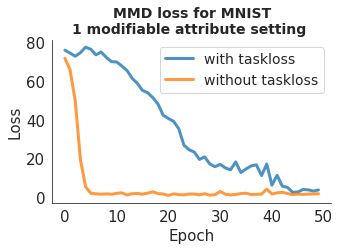

In [45]:
# Plot grid of distributions
labels = ['with taskloss ',
          'without taskloss']
# Experiment list
exp_list = [1,2]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5,3))

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=50)
    
plt.title(f"MMD loss for MNIST\n1 modifiable attribute setting ", fontweight='bold', fontsize=14)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend(loc="upper right", fontsize=14)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(os.path.join(RESULTS_PATH, f'mnist_1attr_MMD_loss.pdf'), bbox_inches='tight', pad_inches=0.1)

We can further confirm succesful learning of the network in this simple case by looking at randomly sampled generated images, and comparing them to a randomly sampled target image. From this we can see that after 2 epochs the network learns to rotate each object to its respective 90 degree position in the 3D scene. 

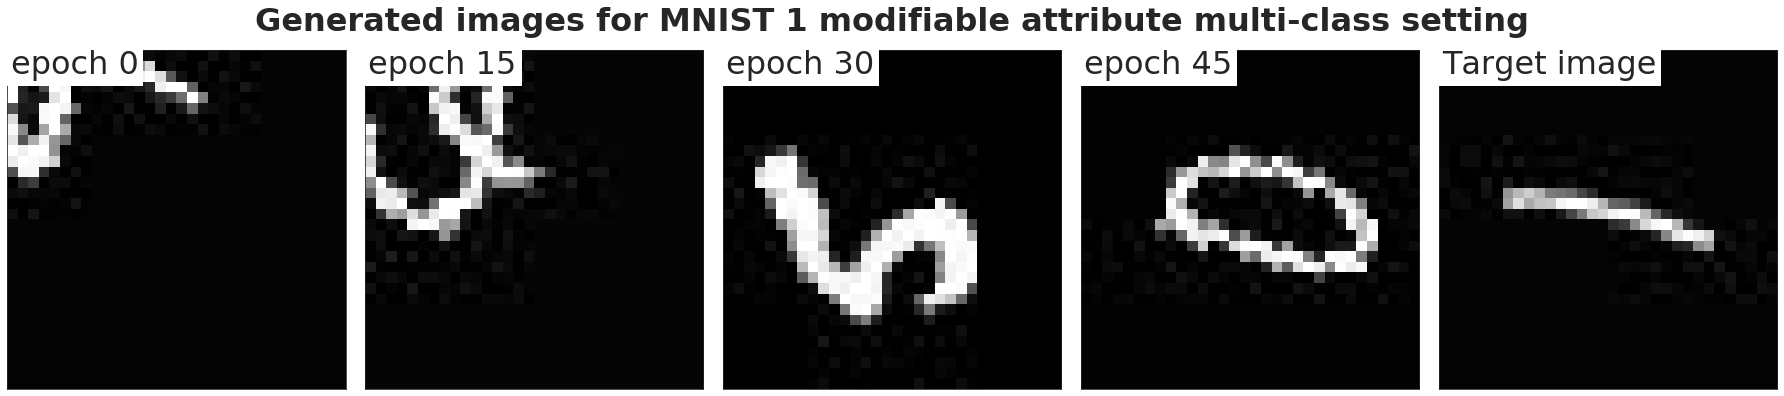

In [60]:
plot_each_image(experiment_n=1, 
                interval=3, 
                total_epochs=50, 
                filename='mnist_1attr_images', 
                title="Generated images for MNIST 1 modifiable attribute multi-class setting")

We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


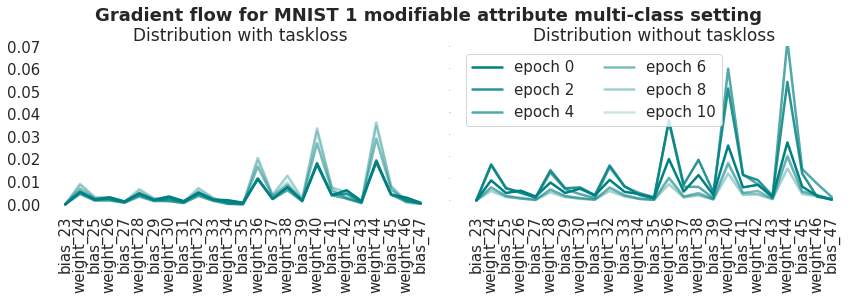

In [82]:
# Plot grid of distributions
titles = ['Distribution with taskloss ',
          'Distribution without taskloss']
# Experiment list
exp_list = [1,2]
# Plot distribution grid
plt.suptitle("Gradient flow for MNIST 1 modifiable attribute multi-class setting",fontsize=18, fontweight='bold', y=1.03)
for i, exp in enumerate(exp_list):
    fig = plot_gradients_grid(experiment_n=exp,
            rows=1,
            columns=2,
            size=(12,4),
            interval=2,
            title=titles[i],
            i=i, 
            limit=11,
            alpha_mult=0.08)
    plt.ylim(top=0.07)
plt.tight_layout()
plt.show()
fig.figure.savefig(os.path.join(RESULTS_PATH, 
            f'mnist_1attr_gradient_flow.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.1)

## **B.2. Learning to rotate 9 digits 90 degrees and change their position**
We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

In [145]:
ROOT_PATH = '../results/mnist/3_attr'
RESULTS_PATH = 'figures/mnist/3_attr/B_2'

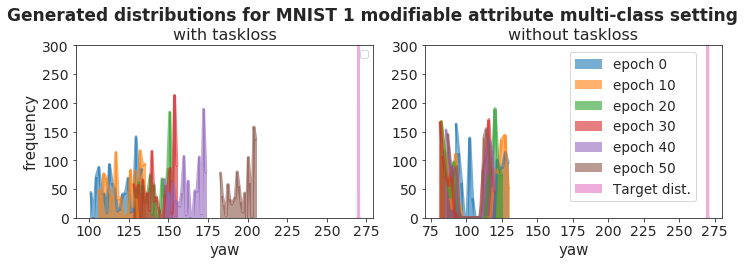

In [150]:
# Plot grid of distributions
titles = ['with taskloss',
          'without taskloss']
# Experiment list
exp_list = [1,2]
# Plot distribution grid
plt.suptitle("Generated distributions for MNIST 1 modifiable attribute multi-class setting", fontsize=17,fontweight='bold', y=1.04)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(experiment=exp, 
                    interval=2,
                    size=(10,3.5),
                    rows=1,
                    columns=2,
                    title=titles[i], i=i)
    plt.ylabel(None)
    plt.ylim(top=300)
    plt.legend(bbox_to_anchor=(0.7,1),loc="upper center",  fontsize=13.5, ncol=1)
    if exp == 1:
        plt.legend("")
    if exp == 1:
        plt.ylabel("frequency")
        
plt.tight_layout()
plt.show()
fig.figure.savefig(os.path.join(RESULTS_PATH, 
            f'mnist_3attr_yawdist.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.1)

We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, Use

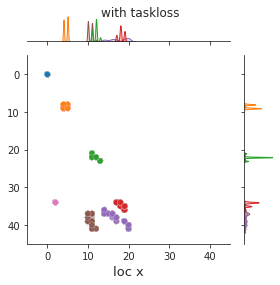

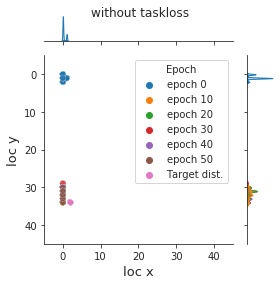

In [158]:
# Plot grid of distributions
titles = ['with taskloss',
          'without taskloss']
# Experiment list
exp_list = [1,2]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    xlabel='loc x'
    if i==1:
        ylabel='loc y'
        legend=True
    else:
        ylabel=None
        legend=False

    plot_loc_dist_grid(experiment_n=exp, 
                    title=titles[i],
                    height=4,
                    filename=f"mnist_3attr_locdistr_{i}",
                    legend=legend, 
                    xlabel=xlabel,
                    ylabel=ylabel)

We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


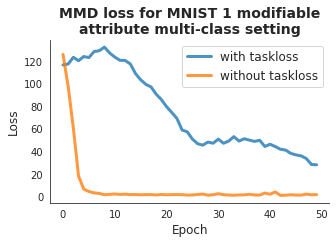

In [159]:
# Plot grid of distributions
labels = ['with taskloss',
          'without taskloss']
# Experiment list
exp_list = [1,2]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5,3))

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=50)
    
plt.title(f"MMD loss for MNIST 1 modifiable\nattribute multi-class setting", fontweight='bold', fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(os.path.join(RESULTS_PATH, f'mnist_3attr_MMD_loss.pdf'), bbox_inches='tight', pad_inches=0.1)

We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


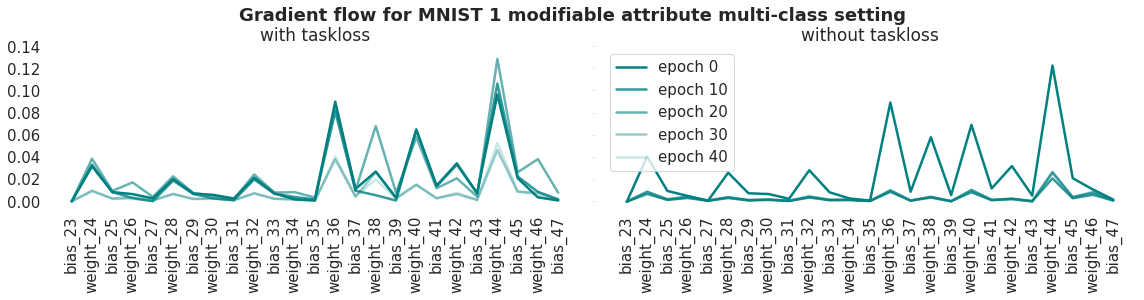

In [161]:
# Plot grid of distributions
titles = ['with taskloss',
          'without taskloss']
# Experiment list
exp_list = [1,2]
# Plot distribution grid
plt.suptitle("Gradient flow for MNIST 1 modifiable attribute multi-class setting", fontsize=18, fontweight='bold', y=1.03)
for i, exp in enumerate(exp_list):
    fig = plot_gradients_grid(experiment_n=exp,
            rows=1,
            columns=2,
            size=(16,4),
            interval=10,
            title=titles[i],
            i=i, 
            limit=50,
            alpha_mult=0.02)
    plt.ylim(top=0.14)
    if i == 1:
        plt.legend(loc="upper left", fontsize=15, ncol=1)
    
    if i > 0:
        plt.yticks(fontsize=0.01)

plt.tight_layout()
plt.show()
fig.figure.savefig(os.path.join(RESULTS_PATH, 
            f'mnist_3attr_gradient_flow.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.12)

We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

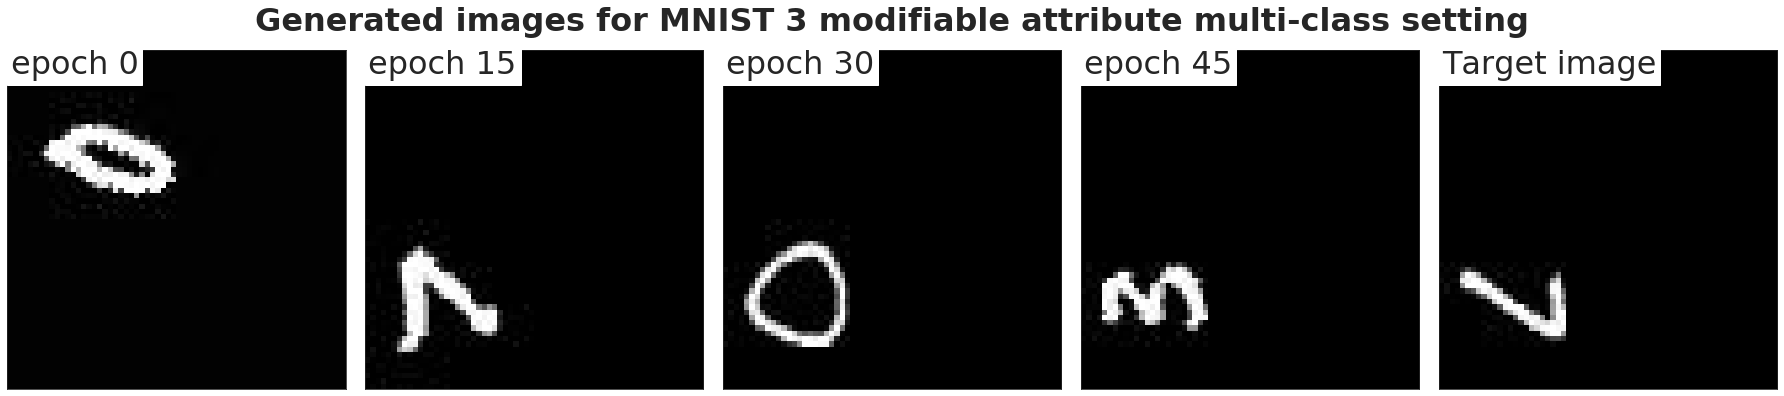

In [162]:
plot_each_image(experiment_n=2, 
                interval=3, 
                total_epochs=50, 
                filename='mnist_3attr_images', 
                title="Generated images for MNIST 3 modifiable attribute multi-class setting")